<a href="https://colab.research.google.com/github/ImaneGuess/Big-Data-Analytics-Projects/blob/main/ViT_Tomato_Leaf_Diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import shutil
import zipfile
import os

# Replace with the actual path to your zipped file in Google Drive
zipped_file_path = '/content/drive/MyDrive/tomatoleaf (2).zip'

# Copy the zipped file to the Colab environment
shutil.copy(zipped_file_path, '/content/')

# Unzip the dataset
with zipfile.ZipFile(zipped_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/tomato_leaf_dataset')

# List the contents of the unzipped directory
!ls /content/tomato_leaf_dataset



tomatoleaf


In [2]:
# Define the paths to the training and validation datasets
train_dir = '/content/tomato_leaf_dataset/tomatoleaf/tomato/train'
val_dir = '/content/tomato_leaf_dataset/tomatoleaf/tomato/val'

Using device: cuda


Loading Validation Images:   0%|          | 0/1000 [00:00<?, ?it/s]

Loading Validation Images:  80%|████████  | 800/1000 [00:06<00:00, 258.21it/s]
Loading Validation Images: 1056it [00:07, 358.42it/s]                         
Loading Validation Images: 1280it [00:07, 501.52it/s]
Loading Validation Images: 1440it [00:07, 580.63it/s]
Loading Validation Images: 1664it [00:07, 778.41it/s]
Loading Training Images: 9024it [00:07, 1132.90it/s]                          
Loading Validation Images: 2048it [00:07, 257.21it/s]
Loading Testing Images:   0%|          | 0/1000 [00:07<?, ?it/s]


Training set size: 9000
Validation set size: 1000
Testing set size: 1000


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/5: 100%|██████████| 282/282 [01:42<00:00,  2.75it/s]


Epoch 1, Loss: 0.1960, Train Accuracy: 94.32%, Val Accuracy: 97.50%


Epoch 2/5: 100%|██████████| 282/282 [01:42<00:00,  2.76it/s]


Epoch 2, Loss: 0.0291, Train Accuracy: 99.13%, Val Accuracy: 98.70%


Epoch 3/5: 100%|██████████| 282/282 [01:41<00:00,  2.76it/s]


Epoch 3, Loss: 0.0040, Train Accuracy: 99.90%, Val Accuracy: 99.20%


Epoch 4/5: 100%|██████████| 282/282 [01:42<00:00,  2.76it/s]


Epoch 4, Loss: 0.0106, Train Accuracy: 99.68%, Val Accuracy: 93.20%


Epoch 5/5: 100%|██████████| 282/282 [01:42<00:00,  2.76it/s]


Epoch 5, Loss: 0.0427, Train Accuracy: 98.66%, Val Accuracy: 95.90%

Evaluating the model on the test set...

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.93      1.00      0.97       100
                        Tomato___Early_blight       0.98      0.89      0.93       100
                         Tomato___Late_blight       0.95      1.00      0.98       100
                           Tomato___Leaf_Mold       1.00      1.00      1.00       100
                  Tomato___Septoria_leaf_spot       1.00      0.81      0.90       100
Tomato___Spider_mites Two-spotted_spider_mite       0.98      0.87      0.92       100
                         Tomato___Target_Spot       0.76      1.00      0.86       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       1.00      0.97      0.98       100
                 Tomato___Tomato_mosaic_virus       1.00      0.98      0.99       

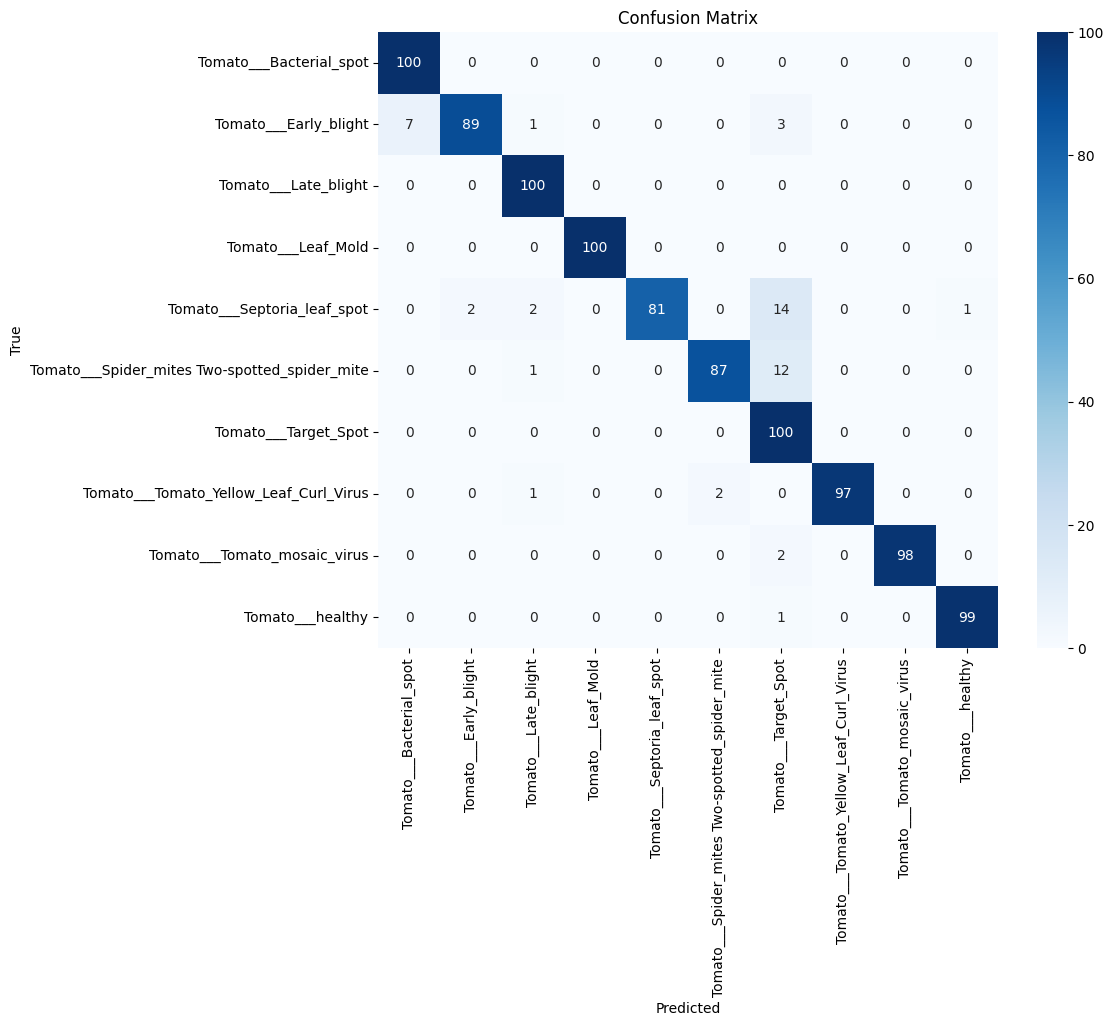

In [5]:
import os
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import ViTImageProcessor, ViTForImageClassification

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        self.class_counts = {cls: 0 for cls in self.classes}

    def __getitem__(self, index):
        try:
            path, target = self.samples[index]
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            self.class_counts[self.classes[target]] += 1
            return sample, target
        except Exception as e:
            print(f"Error loading file at index {index}: {e}")
            # Return a dummy sample to skip this file
            return self[index + 1] if index + 1 < len(self) else self[0]

def evaluate_model_on_test_set(model, test_loader, feature_extractor, device, class_names):
    """
    Evaluates the model on the test set and prints metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Move images and labels to device
            images = images.to(device)
            labels = labels.to(device)

            # Preprocess images using feature extractor
            inputs = feature_extractor(images, return_tensors="pt", do_rescale=False)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Get model predictions
            outputs = model(**inputs)
            _, predicted = torch.max(outputs.logits, 1)

            # Append results
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def main():
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Load the training dataset
    full_train_dataset = CustomImageFolder(root=train_dir, transform=transform)

    # Load the validation dataset
    val_dataset = CustomImageFolder(root=val_dir, transform=transform)

    # Split validation dataset into validation and test sets
    train_indices = []
    test_indices = []

    for class_idx in range(len(full_train_dataset.classes)):
        # Get indices corresponding to the current class
        class_indices = [i for i, (_, label) in enumerate(full_train_dataset.samples) if label == class_idx]

        # Shuffle indices
        class_indices = torch.tensor(class_indices)
        class_indices = class_indices[torch.randperm(len(class_indices))]

        # Split indices: first 900 for training, remaining 100 for testing
        train_indices.extend(class_indices[:900].tolist())
        test_indices.extend(class_indices[900:1000].tolist())

    # Create validation and testing datasets
    train_dataset = Subset(full_train_dataset, train_indices)
    test_dataset = Subset(full_train_dataset, test_indices)

    # Create DataLoader for training and validation datasets
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

    # Print the class names to verify
    #print("Training classes:", train_dataset.classes)
    #print("Validation classes:", val_dataset.classes)

    # Initialize progress bars
    train_progress = tqdm(total=len(train_dataset), desc="Loading Training Images")
    val_progress = tqdm(total=len(val_dataset), desc="Loading Validation Images")
    test_progress = tqdm(total=len(test_dataset), desc="Loading Testing Images")

     # Load all images to count successfully loaded images
    for _ in train_loader:
        train_progress.update(train_loader.batch_size)
    for _ in val_loader:
        val_progress.update(val_loader.batch_size)
    for _ in test_loader:
        val_progress.update(test_loader.batch_size)

    train_progress.close()
    val_progress.close()
    test_progress.close()

    # Print the sizes of the splits
    print(f"Training set size: {len(train_dataset)}")
    print(f"Validation set size: {len(val_dataset)}")
    print(f"Testing set size: {len(test_dataset)}")

  # Load the pretrained ViT model
    model_name = 'google/vit-base-patch16-224'
    feature_extractor = ViTImageProcessor.from_pretrained(model_name)
    model = ViTForImageClassification.from_pretrained(
        model_name,
        num_labels=len(val_dataset.classes),  # Match number of dataset classes
        ignore_mismatched_sizes=True,          # Handle mismatched classifier layers
    )
    model.to(device)

    # Define the training loop
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    num_epochs = 5  # Adjust the number of epochs as needed
    best_val_accuracy = 0.0
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            inputs = feature_extractor(images, return_tensors="pt", do_rescale=False)
            inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to device
            outputs = model(**inputs)
            loss = criterion(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.logits.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        # Evaluate the model on the validation set
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # Move images and labels to the device
                images = images.to(device)
                labels = labels.to(device)
                inputs = feature_extractor(images, return_tensors="pt", do_rescale=False)
                inputs = {key: value.to(device) for key, value in inputs.items()}  # Move to device
                outputs = model(**inputs)
                _, predicted = torch.max(outputs.logits.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        scheduler.step(val_accuracy)

        print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            patience_counter = 0
            torch.save(model.state_dict(), 'tomato_leaf_disease_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Test phase
    #print("\nTesting the model...")
    #correct_test = 0
    #total_test = 0
    #model.eval()
    #with torch.no_grad():
     #   for images, labels in test_loader:
      #      images = images.to(device)
       #     labels = labels.to(device)
        #    inputs = feature_extractor(images, return_tensors="pt", do_rescale=False)
         #   inputs = {key: value.to(device) for key, value in inputs.items()}
          #  outputs = model(**inputs)
           # _, predicted = torch.max(outputs.logits.data, 1)
            #total_test += labels.size(0)
            #correct_test += (predicted == labels).sum().item()

    #test_accuracy = 100 * correct_test / total_test
    #print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Inference phase
    print("\nEvaluating the model on the test set...")
    evaluate_model_on_test_set(model, test_loader, feature_extractor, device, full_train_dataset.classes)

if __name__ == '__main__':
    main()